In [1]:
import sys
sys.path.append('/host/d/Github/')  # add the path to your own Example_UNet folder
import numpy as np
import nibabel as nb 
import pandas as pd
import os
import copy
import random
import Diffusion_denoising_thin_slice.simulation.ct_basic_PCD as ct
import Diffusion_denoising_thin_slice.functions_collection as ff
import ct_projector.projector.numpy.parallel as ct_para

main_path = '/host/d/Data/low_dose_CT/'  # change to your own data path

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the patient list
patient_sheet = ff.find_all_target_files(['nii_imgs/*'],main_path)
print('Found {} patients'.format(len(patient_sheet)))

Found 10 patients


In [4]:
i= 0 
img_file = os.path.join(patient_sheet[i],'img.nii.gz')
img_clean = nb.load(img_file).get_fdata().astype(np.float32)
affine = nb.load(img_file).affine
img_clean[img_clean < -1024] = -1024

# exclude the first two and last two slices
img_clean = img_clean[:,:,2:-2]

# load bed segmentations
bed_seg_file = os.path.join(patient_sheet[i], 'bed_seg.nii.gz')
bed_seg = np.round(nb.load(bed_seg_file).get_fdata())
bed_seg = bed_seg[:,:,2:-2]
print('unique bed seg values:', np.unique(bed_seg))

# exclude pixels belonging to the bed
img_removed = np.copy(img_clean)
img_removed[bed_seg == 1] = -1024
img_removed[:,0:20,:] = -1024  
nb.save(nb.Nifti1Image(img_removed, affine),os.path.join(patient_sheet[i],'img_no_bed.nii.gz'))



unique bed seg values: [0. 1.]


In [27]:
from scipy.ndimage import binary_fill_holes
i=0
a = nb.load(os.path.join(patient_sheet[i],'img_no_bed.nii.gz')).get_fdata().astype(np.float32)
segmented_img = np.zeros_like(a)
object_mask = np.zeros_like(a)
for s in range(a.shape[2]):
    slice_img = a[:,:,s]
    slice_mask = np.zeros_like(slice_img)
    slice_mask[slice_img>=-430]= 1
    slice_mask[slice_img<-430]= 0
    filled_mask = binary_fill_holes(slice_mask)
    slice_img_segmented = np.copy(slice_img)
    slice_img_segmented[filled_mask==0] = np.min(slice_img)
    object_mask[:,:,s] = filled_mask
    segmented_img[:,:,s] = slice_img_segmented

(-0.5, 511.5, 511.5, -0.5)

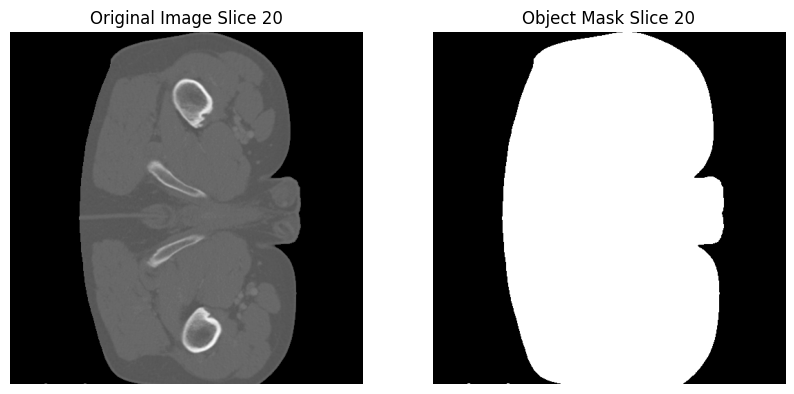

In [28]:
# plot a slice image and mask side by side
import matplotlib.pyplot as plt
slice_n = 20
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(segmented_img[:,:,slice_n], cmap='gray')
plt.title('Original Image Slice {}'.format(slice_n))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(object_mask[:,:,slice_n], cmap='gray')
plt.title('Object Mask Slice {}'.format(slice_n))
plt.axis('off')


In [29]:
nb.save(nb.Nifti1Image(segmented_img, affine), os.path.join(patient_sheet[i],'img_no_bed_segmented.nii.gz'))
nb.save(nb.Nifti1Image(object_mask, affine), os.path.join(patient_sheet[i],'object_mask.nii.gz'))

In [ ]:
for i in range(0,1):
    patient_id = os.path.basename(patient_sheet[i])

    print(patient_id)

    save_folder_case = os.path.join(main_path,'simulation_v1', patient_id)
    ff.make_folder([os.path.dirname(save_folder_case), save_folder_case])

    # for dose factor in range 0.30-0.9 with step 0.05
    # possion_hann_dose_range = [0.60,0.80]
    # gaussian_custom_dose_range = [0.085,0.1]

    # img file
    img_file = os.path.join(patient_sheet[i],'img_no_bed_segmented.nii.gz')
    print(img_file)
    # load img
    img_clean = nb.load(img_file).get_fdata().astype(np.float32)[:,:,150:200]
    img_clean[img_clean < -1024] = -1024
    spacing = nb.load(img_file).header.get_zooms()[::-1]
    affine = nb.load(img_file).affine
    print('img shape, min, max: ', img_clean.shape, np.min(img_clean), np.max(img_clean))
    print('spacing: ', spacing)

    for noise_type in ['gaussian']:#['possion', 'gaussian']:
        # by vusialization we decided the following dose range
        possion_hann_dose_range = [0.10,0.20]
        gaussian_custom_dose_range = [0.15,0.25]
        
        for k in range(0,1):
            save_folder_k = os.path.join(save_folder_case, noise_type+'_random_'+str(k));ff.make_folder([save_folder_k])
            # if os.path.isfile(os.path.join(save_folder_k,'recon_odd.nii.gz')):
            #     print('already done, continue')
                # continue

            if noise_type == 'possion':
                dose_factor = np.random.uniform(possion_hann_dose_range[0],possion_hann_dose_range[1] + 1e-8)
                print('dose factor: ', dose_factor)
            elif noise_type == 'gaussian':
                dose_factor = np.random.uniform(gaussian_custom_dose_range[0],gaussian_custom_dose_range[1] + 1e-8)
            

            # process img
            img0 = img_clean.copy()
            img0 = np.rollaxis(img0,-1,0)
      
            # define projectors
            geometry_file = '/host/d/Github/Diffusion_denoising_thin_slice/help_data/pcd_parallel_6x5_512.cfg'  # change to your own path
            projector = ct.define_forward_projector_pcd(img0,spacing, file_name = geometry_file)
            # FP
            # set angles
            angles = projector.get_angles()

            recon_noise = np.zeros((img0.shape[1], img0.shape[2], img0.shape[0]), np.float32)
            for slice_n in range(0, img0.shape[0]):
                img_slice = img0[[slice_n],:,:].copy()
                img_slice = (img_slice[np.newaxis, ...] + 1000) / 1000 * 0.019 
                
                # forward proj
                prjs = ct_para.distance_driven_fp(projector, img_slice, angles)
                # ramp filter for image
                fprjs = ct_para.ramp_filter(projector, prjs, 'rl')

                # add noise
                if noise_type[0:2] == 'po':
                    # add poisson noise
                    noise_of_prjs = ct.add_poisson_noise(prjs, N0=1000000, dose_factor = dose_factor) - prjs
                elif noise_type[0:2] == 'ga':
                    # add gaussian noise
                    noise_of_prjs = ct.add_gaussian_noise(prjs, N0=1000000, dose_factor = dose_factor) - prjs

                # recon
                if noise_type[0:2] == 'po':
                    # hann filter for noise projs
                    fnoise = ct_para.ramp_filter(projector, noise_of_prjs, 'hann')

                    # bp for noise
                    recon_hann_noise = ct_para.distance_driven_bp(projector, fnoise, angles, True) 
                
                    # bp for image
                    recon_hann_image = ct_para.distance_driven_bp(projector, fprjs, angles, True)
                   
                    # final recon
                    recon_hann = (recon_hann_noise +recon_hann_image)[0,0] / 0.019 * 1000 - 1000
                   
                    
                    recon_noise[:,:,slice_n] = recon_hann
                    
                
                elif noise_type[0:2] == 'ga':
                    # custom filter
                    custom_filter_file = '/host/d/Github/Diffusion_denoising_thin_slice/help_data/softTissueKernel_65'  # change to your own path
                    custom_additional_filter = ct.get_additional_filter_to_rl(custom_filter_file, projector.nu, projector.du, projector.nview)
                    recon_custom_noise = ct.interleave_filter_and_recon(projector, noise_of_prjs, custom_additional_filter,angles) 
                    recon_custom_image = ct.interleave_filter_and_recon(projector, prjs, custom_additional_filter, angles)
                    
                    recon_custom = (recon_custom_noise + recon_custom_image)/ 0.019 * 1000 - 1000
                    recon_noise[:,:,slice_n] = recon_custom
            # save recon
            nb.save(nb.Nifti1Image(img_clean, affine), os.path.join(save_folder_case,'img_clean.nii.gz'))
            nb.save(nb.Nifti1Image(recon_noise, affine), os.path.join(save_folder_k,'recon.nii.gz'))
            diff = recon_noise - img_clean
            nb.save(nb.Nifti1Image(diff, affine), os.path.join(save_folder_k,'diff.nii.gz'))
            print('Saved recon and diff')


            

L067
/host/d/Data/low_dose_CT/nii_imgs/L067/img_no_bed_segmented.nii.gz
img shape, min, max:  (512, 512, 50) -1024.0 1429.0
spacing:  (2.0, 0.6640625, 0.6640625)


In [33]:
# post process
object_mask =np.round( nb.load(os.path.join(patient_sheet[i],'object_mask.nii.gz')).get_fdata())[:,:,150:200]
recon_processed = np.copy(recon_noise)
recon_processed[object_mask==0] = -1024
nb.save(nb.Nifti1Image(recon_processed, affine), os.path.join(save_folder_k,'recon_processed.nii.gz'))

In [18]:
def split_angles_indexes(total_angles):
    arr = np.arange(total_angles)
    # 将每两个连续的数分成一组
    pairs = arr.reshape(-1, 2)  # 结果是 shape (720, 2)

    # 初始化两个列表 A 和 B
    A = []
    B = []

    # 在每对中随机选一个加入 A，另一个加入 B
    for pair in pairs:
        idx = random.randint(0, 1)  # 随机选 0 或 1
        A.append(pair[idx])
        B.append(pair[1 - idx])

    # 转换为 NumPy array（可选）
    A = np.array(A)
    B = np.array(B)
    return A,B

In [19]:
# odd_indexes, even_indexes = split_angles_indexes(1440)
# angles_odd = angles[odd_indexes]
# angles_even = angles[even_indexes]
# noisy_prjs_odd = noisy_prjs[:, odd_indexes, ...]
# noisy_prjs_even = noisy_prjs[:, even_indexes, ...]
# noise_of_prjs_odd = noise_of_prjs[:, odd_indexes, ...]
# noise_of_prjs_even = noise_of_prjs[:, even_indexes, ...]


# recon
recon_noise_odd = np.zeros((img0.shape[1], img0.shape[2], img0.shape[0]), np.float32)
recon_noise_even = np.zeros((img0.shape[1], img0.shape[2], img0.shape[0]), np.float32)
for slice_n in range(0, img0.shape[0]):
    img_slice = img0[[slice_n],:,:].copy()
    img_slice = (img_slice[np.newaxis, ...] + 1000) / 1000 * 0.019 

    prjs = ct_para.distance_driven_fp(projector, img_slice, angles)
    fprjs = ct_para.ramp_filter(projector, prjs, 'rl')

    # add noise
    if noise_type[0:2] == 'po':
        # add poisson noise
        noise_of_prjs = ct.add_poisson_noise(prjs, N0=1000000, dose_factor = dose_factor) - prjs
        noisy_prjs = prjs + noise_of_prjs
    elif noise_type[0:2] == 'ga':
        # add gaussian noise
        noise_of_prjs = ct.add_gaussian_noise(prjs, N0=1000000, dose_factor = dose_factor) - prjs
        noisy_prjs = prjs + noise_of_prjs
    
    odd_indexes, even_indexes = split_angles_indexes(1440)
    angles_odd = angles[odd_indexes]
    angles_even = angles[even_indexes]

    if noise_type[0:2] == 'po':
        # hann filter
        fnoise = ct_para.ramp_filter(projector, noise_of_prjs, 'hann')
        # devide fnoise into odd and even
        fnoise_odd = fnoise[:, odd_indexes, ...]
        fnoise_even = fnoise[:, even_indexes, ...]
        
        # do on odd
        recon_hann_odd = ct_para.distance_driven_bp(projector, fnoise_odd, angles_odd, True)  + img_slice
        recon_hann_odd = recon_hann_odd[0, 0] / 0.019 * 1000 - 1000
        recon_noise_odd[:,:,slice_n] = recon_hann_odd

        # do on even
        recon_hann_even = ct_para.distance_driven_bp(projector, fnoise_even, angles_even, True)  + img_slice
        recon_hann_even = recon_hann_even[0, 0] / 0.019 * 1000 - 1000
        recon_noise_even[:,:,slice_n] = recon_hann_even
                    
    elif noise_type[0:2] == 'ga':
        # custom filter
        custom_filter_file = '/host/d/Github/Diffusion_denoising_thin_slice/help_data/softTissueKernel_65'  # change to your own path
        custom_additional_filter = ct.get_additional_filter_to_rl(custom_filter_file, projector.nu, projector.du, projector.nview)
        # device noise_of_prjs into odd and even
        noise_of_prjs_odd = noise_of_prjs[:, odd_indexes, ...]
        noise_of_prjs_even = noise_of_prjs[:, even_indexes, ...]

        # do on odd
        recon_custom_odd = ct.interleave_filter_and_recon(projector, noise_of_prjs_odd, custom_additional_filter,angles_odd) + img_slice
        recon_custom_odd = recon_custom_odd[0, 0] / 0.019 * 1000 - 1000
        recon_noise_odd[:,:,slice_n] = recon_custom_odd

        # do on even
        recon_custom_even = ct.interleave_filter_and_recon(projector, noise_of_prjs_even, custom_additional_filter,angles_even) + img_slice
        recon_custom_even = recon_custom_even[0, 0] / 0.019 * 1000 - 1000
        recon_noise_even[:,:,slice_n] = recon_custom_even

# save recon
nb.save(nb.Nifti1Image(img_clean, affine), os.path.join(save_folder_k,'img_clean.nii.gz'))
nb.save(nb.Nifti1Image(recon_noise_odd, affine), os.path.join(save_folder_k,'recon_odd.nii.gz'))
nb.save(nb.Nifti1Image(recon_noise_even, affine), os.path.join(save_folder_k,'recon_even.nii.gz'))
diff_odd = recon_noise_odd - img_clean
diff_even = recon_noise_even - img_clean
diff_between_odd_even = recon_noise_odd - recon_noise_even
nb.save(nb.Nifti1Image(diff_odd, affine), os.path.join(save_folder_k,'diff_odd_clean.nii.gz'))
nb.save(nb.Nifti1Image(diff_even, affine), os.path.join(save_folder_k,'diff_even_clean.nii.gz'))
nb.save(nb.Nifti1Image(diff_between_odd_even, affine), os.path.join(save_folder_k,'diff_between_odd_even.nii.gz'))

GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)
fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)
cFilterParallelFilter() failed: fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)(no error)
GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)
fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)
cFilterParallelFilter() failed: fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)(no error)
GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)
fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)
cFilterParallelFilter() failed: fbpParallel::Filter() failed: GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)(no error)(no error)
GetRamp() failed: cufftPlan1d failure in GetRamp()(no error)
fbpParallel::Filter() fa